# 이미지 100개 정도를 벡터화

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

사전 학습된 모델 생성

In [2]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.vgg16 import preprocess_input
#
# def get_model():
#     pretrained_vgg16 = VGG16(weights="imagenet", include_top=True)
#     return Model(inputs=pretrained_vgg16.input, outputs=pretrained_vgg16.get_layer('fc2').output)

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from efficientnet.keras import preprocess_input

def get_model():
    pretrained_efficientnet = EfficientNetB0(weights="imagenet", include_top=True)
    return Model(inputs=pretrained_efficientnet.input, outputs=pretrained_efficientnet.get_layer('top_dropout').output)

2023-06-06 02:03:46.597786: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model = get_model()

deepFashion 이미지 중 일부를 벡터화

In [5]:
from tensorflow.keras.preprocessing import image

def read_txt_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return [line.strip() for line in lines]


def generate_features(image_paths):
    images = np.zeros(shape=(len(image_paths), 224, 224, 3))
    for i, f in enumerate(image_paths):
        img = image.load_img(f, target_size=(224, 224))
        x_raw = image.img_to_array(img)
        x_expand = np.expand_dims(x_raw, axis=0)
        images[i, :, :, :] = x_expand
    inputs = preprocess_input(images)
    images_features = model.predict(inputs)
    return images_features


root_path = '/Users/user/workspace/personal/practice-mlops/2.build-tensorflow-model/data'
image_paths = read_txt_file(root_path + '/val.txt')
image_paths = [os.path.join(root_path, path) for path in image_paths]

features = generate_features(image_paths)

category_numbers = read_txt_file(root_path + '/val_cate.txt')
category_numbers = [int(num) for num in category_numbers]

category_list = read_txt_file(root_path + '/list_category_cloth.txt')[2:]  # Skip first two lines

categories = [category_list[num-1] for num in category_numbers]  # 1-indexed

63/63 [==============================] - 67s 1s/step


# 벡터화된거 차원축소해서 클러스터링 해본다

PCA, UMAP, t-SNE 등을 통해 2차원 차원 축소 후 클러스터링 시각화를 해볼 수 있다

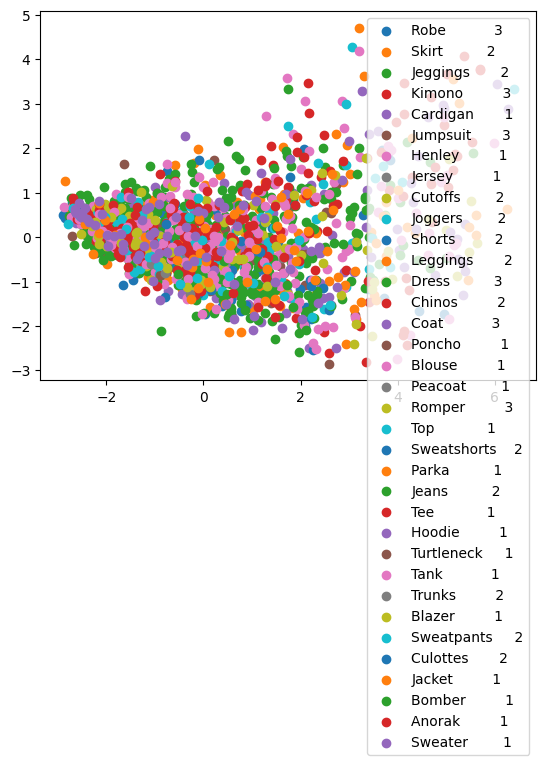

In [6]:
from sklearn.decomposition import PCA

# Applying PCA to reduce the features to 2D for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features)

fig, ax = plt.subplots()

for category in set(categories):
    ix = np.where(np.array(categories) == category)
    ax.scatter(principalComponents[ix, 0], principalComponents[ix, 1], label=category)

ax.legend()
plt.show()

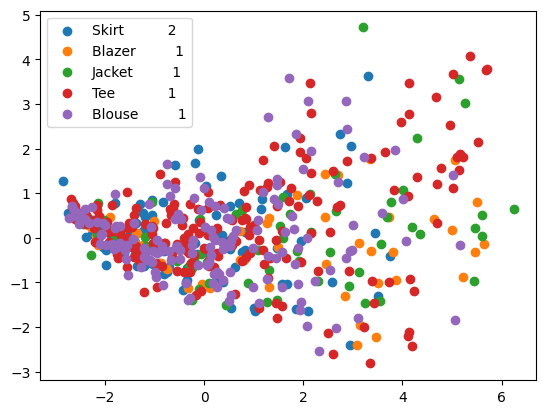

In [7]:
from sklearn.decomposition import PCA

# Select a subset of categories to visualize
selected_categories = set(categories[:5])  # Select the first 5 categories

# Applying PCA to reduce the features to 2D for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features)

fig, ax = plt.subplots()

for category in selected_categories:
    ix = np.where(np.array(categories) == category)
    ax.scatter(principalComponents[ix, 0], principalComponents[ix, 1], label=category)

ax.legend()
plt.show()

차원이 높아서 그런지, 아니면 사용한 모델이 문제인지, 아니면 fashion 중 특정 옷들에 대한 분류가 어려운건지 클러스터링이 제대로 된 것 같지는 않다